*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module02_03_pca.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Principal Components Analysis (PCA)

In this notebook we introduce a principled manner of selecting a smaller dimensional subspace in which to represent our data.

This will provide multiple advantages:
* Better ability to visualize high dimensional data
* Faster computations
* Potentially improved accuracy as a result of removal of noise.

## What is PCA

There are many ways to introduce Principal Components Analysis (PCA).  Here we choose a visual way of introducing this topic.


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

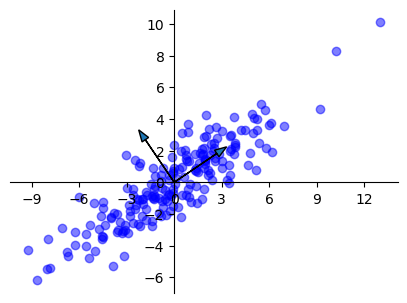

In [189]:
from sklearn.datasets import make_blobs
# create data with a single class:
X_initial, y = make_blobs(n_samples=200, n_features=2, 
                          centers=[[0.0,0.0]], cluster_std=[[4.0,1.0]], 
                          shuffle=True, random_state=2)
# Rotate the data
theta = np.radians(35)
rotation = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
X = np.dot(X_initial, np.transpose(rotation))

# apply PCA
pca = PCA(2)
pca.fit(X)
components = pca.components_

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
#ax.set_aspect('equal')
ax.scatter(X[:,0], X[:,1], color='b', alpha=0.5)

plt.arrow(0,0, components[0][0]*4,components[0][1]*4, 
          head_width=0.5, ec='k', 
          length_includes_head=True)

plt.arrow(0,0, components[1][0]*4,components[1][1]*4, 
          head_width=0.5, ec='k', 
          length_includes_head=True)

from matplotlib.ticker import MaxNLocator
def axes_at_zero(ax):
    """helper to make the axes go through (0,0)"""
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_aspect('equal')
    
axes_at_zero(ax)


The first principal component can be explained as follows: It is the direction along which the variance of the data is largest.  Consider all possible directions in the space in which the data lives.  For all such directions, the data may be projected onto that direction and then the variance calculated.  Unless there are ties (highly unlikely), there will exist a unique direction that has higher variance than all others. 
That is the first principal component.  The above "toy" data generated by sampling from a two dimensional Gaussian distribution, illustrates the idea.

In the above code we would like to highlight the commands used to train the PCA object and obtain the pricipal components:

```Python
pca = PCA(2)  # create a PCA object that produces to PCs
pca.fit(X)    # train the PCA object
components = pca.components_  # retrive the PCs from the PCA object
```

For $d$ dimensional data, the matrix of principle components is a $d \times d$ matrix.

Let's compare the matrix used to rotate the data to the vectors learned by PCA:

In [109]:
# the matrix we used for rotating the data:
rotation

array([[ 0.81915204, -0.57357644],
       [ 0.57357644,  0.81915204]])

In [110]:
# the vectors (principal components) learned by PCA:
components

array([[ 0.82820362,  0.5604273 ],
       [-0.5604273 ,  0.82820362]])

We extracted these components from the trained PCA object, stored in its `components_` attribute.  We can verify that these are unit vectors that are orthogonal to each other:

In [112]:
np.linalg.norm(components[0]),np.linalg.norm(components[1])

(1.0, 1.0)

In [113]:
np.dot(components[0], components[1])

0.0

Think of these as an alternative **coordinate system** in which to represent the data.

Let's represent the data in the space of the principal components:

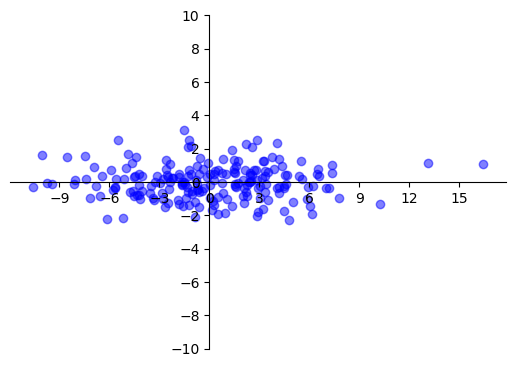

In [115]:
X_pca = pca.transform(X)
# An alternative way to compute the PCA-transformed data:
# X_pca = np.dot(X, np.transpose(components))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_pca[:,0], X_pca[:,1], color='b', alpha=0.5)

axes_at_zero(ax)
ax.set_ylim(-10, 10);

### Digression:  coordinate systems

A coordinate system is a way for us to determine the position of a point in space.  Mathematically, it is defined as a collection of unit vectors that are orthogonal to each other (i.e. orthonormal).  Such a collection is called a **basis**.

**Example:** The Euclidean coordinate system.  
Suppose we are working in a $d$ dimensional space, then the Euclidean coordinate system is defined by orthonormal vectors $\mathbf{e}_1,\ldots,\mathbf{e}_d$, where $\mathbf{e}_i$ is a unit vector with a single non-zero coefficient.

Given an orthonormal basis we can express a vector $\mathbf{x}$ as:

$$
\mathbf{x} = \sum_{i=1}^d x_i \mathbf{e}_i = \sum_{i=1}^d (\mathbf{x}^\top \mathbf{e}_i) \mathbf{e}_i.
$$

### PCA as a new basis

In PCA, all we are doing is expressing a vector in a new coordinate system, with an orthonormal basis defined by the principal components.
So, instead of the standard Euclidean basis we use a new basis 
$$
\mathbf{v}_1,\ldots,\mathbf{v}_d.
$$

### Dimensionality reduction using PCA 


Next, we will use PCA to reduce the dimensionality of a vector by representing it using the first $k$ principal components.  In the basis of the principal components, we will replace a $d$-dimensional vector $\mathbf{x}$ with 
$$
\mathbf{z} = \left( \mathbf{x}^\top \mathbf{v}_1,\ldots,\mathbf{x}^\top \mathbf{v}_k \right)^\top.
$$

In the above code this was implemented as:

```Python
X_pca = np.dot(X, np.transpose(components))
```
Note that this applies the above equation to an entire dataset!

### PCA on the digits dataset

Next, let's apply PCA to a more interesting dataset, the digits dataset:

In [118]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [183]:
# load the data
digits = datasets.load_digits()
X = digits.data
y = digits.target
# standardize the data:
scaler = StandardScaler(with_mean=True, with_std=False).fit(X)
X = scaler.transform(X)
X.shape

(1797, 64)

In [120]:
num_components = 20
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
X_pca.shape

(1797, 20)

In [121]:
pca.components_.shape

(20, 64)

Now, let's visualize the first two principal components:

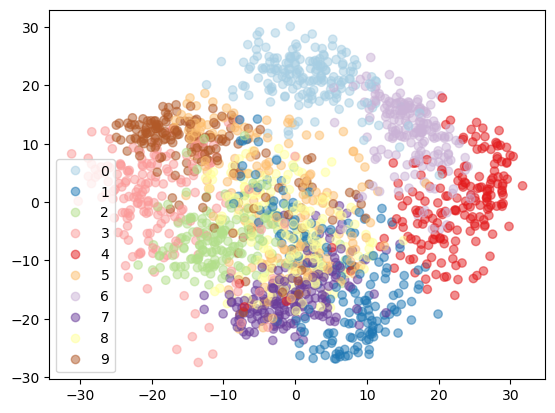

In [123]:
scatter=plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=y, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(10));

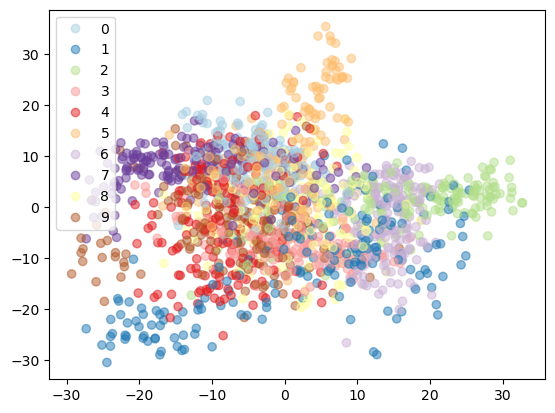

In [124]:
scatter=plt.scatter(X_pca[:, 2], X_pca[:, 3], alpha=0.5, c=y, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(10));

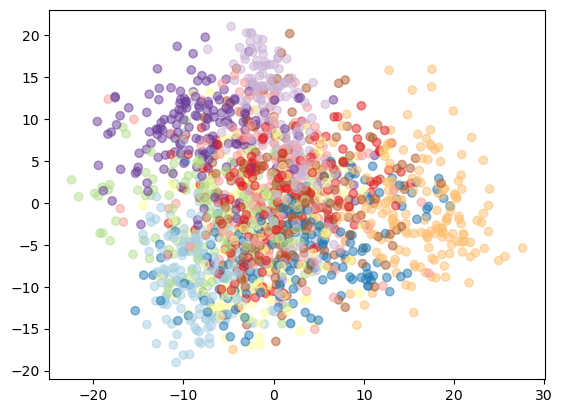

In [125]:
plt.scatter(X_pca[:, 4], X_pca[:, 5], alpha=0.5, c=y, cmap=plt.cm.Paired);

### Variance explained

As we discussed above, the components of PCA are constructed as directions of high variance in the data.  The following plots shows this for the digits data:

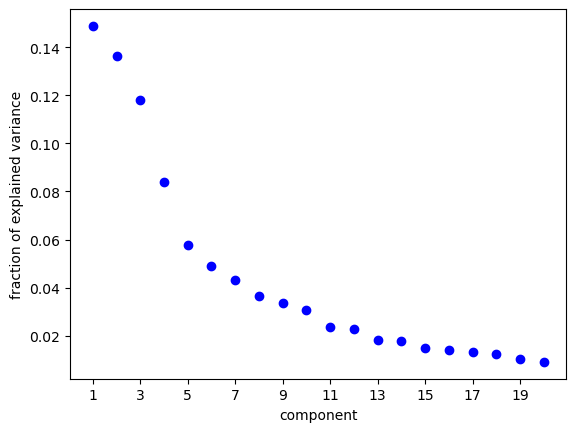

In [127]:
plt.plot(range(1, num_components + 1), pca.explained_variance_ratio_, 'ob')
plt.xlabel("component")
plt.xticks(range(1,num_components+1, 2))
plt.ylabel("fraction of explained variance");

### PCA on yeast gene expression data

Just to convince you that the grouping we have observed in the space of the principal components of the digits data is not an isolated example, we will use a dataset of yeast gene expression:

In [129]:
data = np.loadtxt("https://github.com/asabenhur/CS345/raw/master/fall22/data/yeast.data", delimiter = ",")
data.shape

(527, 80)

In [130]:
y=data[:,0]
# the data has a bunch of examples whose functional class 
# is unkown.  we'll discard those:
X=data[y>=0,1:]
y=y[y>=0]
scaler = StandardScaler(with_std=False).fit(X)
X = scaler.transform(X)
X.shape

(227, 79)

Let's apply PCA to the data and keep the first 20 principal components:

In [132]:
num_components = 20
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
X_pca.shape

(227, 20)

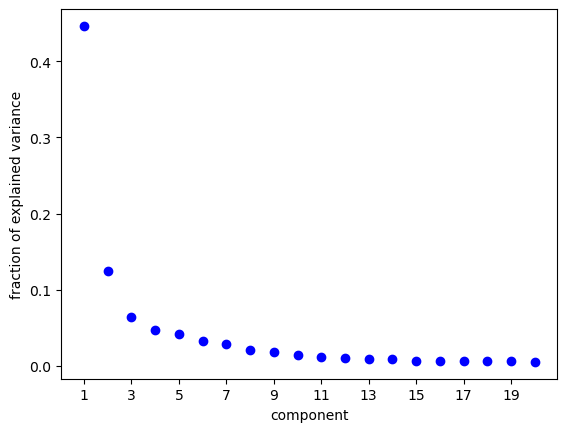

In [133]:
plt.plot(range(1, num_components + 1), pca.explained_variance_ratio_, 'ob')
plt.xlabel("component")
plt.xticks(range(1,num_components+1, 2))
plt.ylabel("fraction of explained variance");

Now, let's visualize the first two principal components:

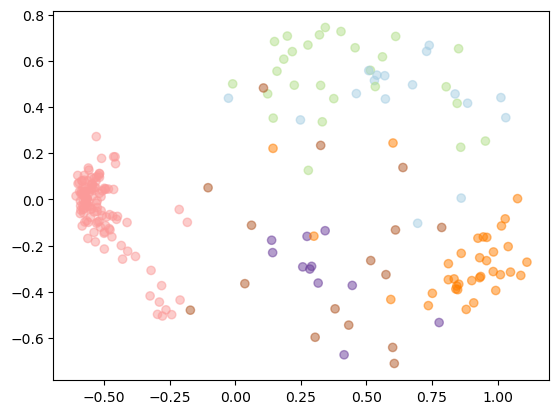

In [135]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=y, cmap=plt.cm.Paired);

Let's take a look at the next two principal components:

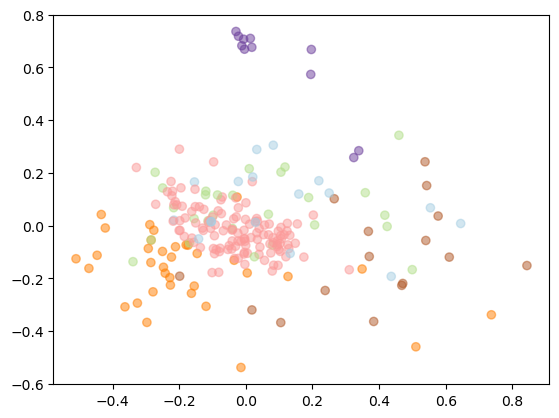

In [137]:
plt.scatter(X_pca[:, 2], X_pca[:, 3], alpha=0.5, c=y, cmap=plt.cm.Paired);

Let's go higher:

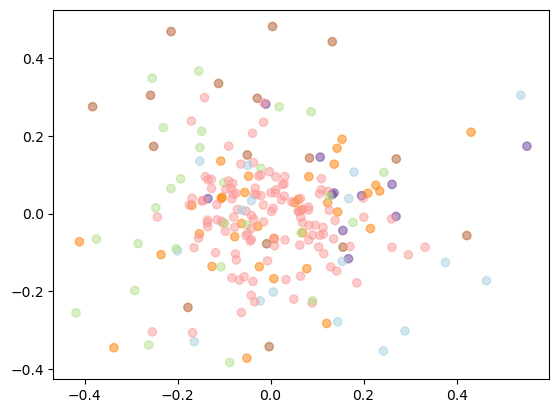

In [139]:
plt.scatter(X_pca[:, 5], X_pca[:, 6], alpha=0.5, c=y, cmap=plt.cm.Paired);

### Other methods

PCA wasn't specifically designed to provide a low dimensional representation of data for visualization purposes, although it does that quite well.  There exist purpose built methods for that purpose.  Some of these are available in [scikit-learn](https://scikit-learn.org/stable/modules/manifold.html), and other notable methods include [UMAP](https://umap.scikit-tda.org/index.html) and [PaCMAP](https://github.com/YingfanWang/PaCMAP).
We will apply the [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) method which is available in scikit-learn and compare it with PCA on the digits data.  First, PCA again:

In [142]:
# load the data
digits = datasets.load_digits()
X = digits.data
y = digits.target
# standardize the data:
scaler = StandardScaler(with_mean=True, with_std=False).fit(X)
X = scaler.transform(X)
X.shape

(1797, 64)

In [143]:
num_components = 2
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
X_pca.shape

(1797, 2)

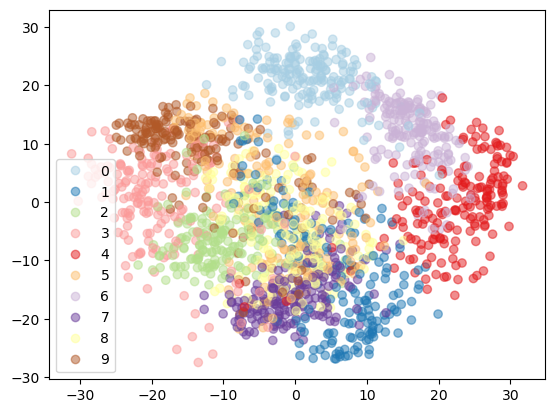

In [144]:
scatter=plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=y, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(10));

Now, let's see what t-SNE does on this data:

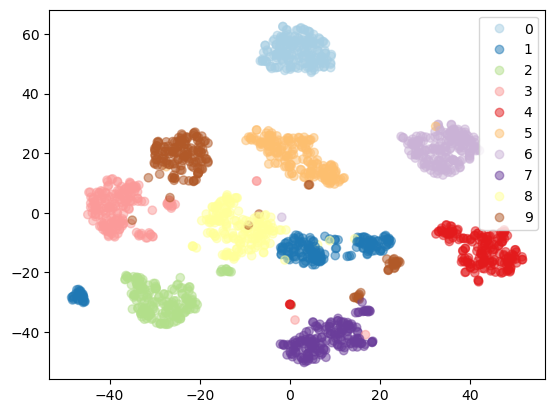

In [146]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2).fit_transform(X)
scatter=plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, c=y, 
                    cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(10));

Apply it again, and you will see a different result:

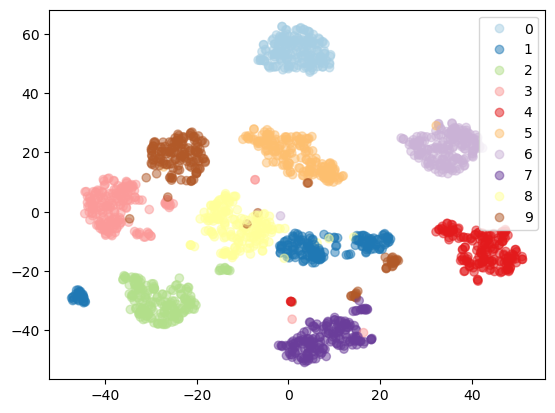

In [148]:
X_tsne = TSNE(n_components=2).fit_transform(X)
scatter=plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, c=y, cmap=plt.cm.Paired);
plt.legend(handles=scatter.legend_elements()[0], labels=range(10));

This is because there is an element of randomness in the algorithm.  We also haven't discussed the t-SNE hyperparameter (called perplexity), which also contributes to the observed structure.

### Summary

We have seen the value of PCA and t-SNE for visualizing high dimensional datasets.  This is useful to see patterns in the data before applying supervised learning techniques.  It is also a good idea to do this to see if there are any issues in the data; as you can see above, it can also help us detect potential mis-labeled examples.